In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
train_df.drop(['id', 'Podcast_Name', 'Episode_Title'], axis=1, inplace=True)

In [5]:
# Handle missing values
for column in train_df.columns:
    if train_df[column].isnull().sum() > 0:
        if train_df[column].dtype == 'object':
            train_df[column].fillna(train_df[column].mode()[0], inplace=True)
        else:
            train_df[column].fillna(train_df[column].mean(), inplace=True)

# Encode categorical features
label_encoders = {}
for column in ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    label_encoders[column] = le


/var/folders/n6/jqpfr3890bzfbbynf468429c0000gp/T/ipykernel_41410/1100446109.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(train_df[column].mean(), inplace=True)


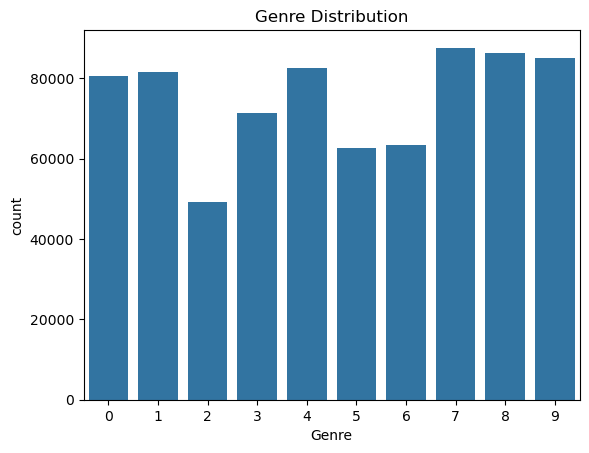

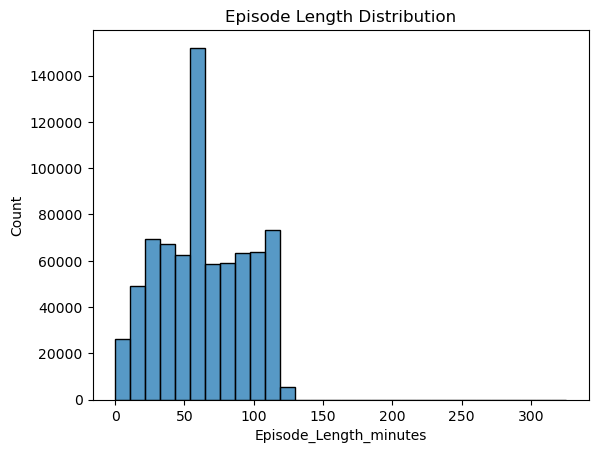

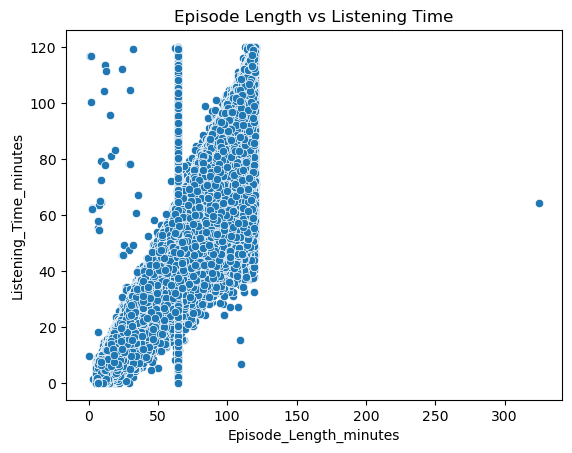

In [6]:
sns.countplot(x='Genre', data=train_df)
plt.title('Genre Distribution')
plt.show()

sns.histplot(train_df['Episode_Length_minutes'], bins=30)
plt.title('Episode Length Distribution')
plt.show()

sns.scatterplot(x='Episode_Length_minutes', y='Listening_Time_minutes', data=train_df)
plt.title('Episode Length vs Listening Time')
plt.show()


In [7]:
X = train_df.drop('Listening_Time_minutes', axis=1)
y = train_df['Listening_Time_minutes']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f'{model_name} R²:', r2)
    print(f'{model_name} MAE:', mae)
    print(f'{model_name} RMSE:', rmse)

In [10]:
evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")


Random Forest R²: 0.7781886416374763
Random Forest MAE: 9.039068368849849
Random Forest RMSE: 12.77555716540579
XGBoost R²: 0.7689955443151846
XGBoost MAE: 9.4744452448263
XGBoost RMSE: 13.03761455165324


In [11]:
best_model = xgb_model if r2_score(y_test, xgb_model.predict(X_test)) > r2_score(y_test, rf_model.predict(X_test)) else rf_model

In [12]:
# Preprocess Test Data
test_ids = test_df['id'] 
test_df.drop(['id'], axis=1, inplace=True)  


for column in test_df.columns:
    if test_df[column].isnull().sum() > 0:
        if test_df[column].dtype == 'object':
            test_df[column].fillna(test_df[column].mode()[0], inplace=True)
        else:
            test_df[column].fillna(test_df[column].mean(), inplace=True)


for column in ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    le = label_encoders[column]
    test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)


test_predictions = best_model.predict(test_df)

# Create Submission File
submission_df = pd.DataFrame({'id': test_ids, 'Listening_Time_minutes': test_predictions})
submission_df.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')

/var/folders/n6/jqpfr3890bzfbbynf468429c0000gp/T/ipykernel_41410/495771264.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[column].fillna(test_df[column].mean(), inplace=True)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Episode_Title
- Podcast_Name
